In [1]:
%matplotlib inline

import math

from models.vae import get_vae
from models.rnn import get_rnn
from tensorflow.keras.utils import HDF5Matrix
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# Load Data

In [2]:
def scale(a):
    return a / 255

In [3]:
start = 0
end = start + 10000
obs = HDF5Matrix('data/test.h5', 'obs', start=start, end=end, normalizer=scale)
actions = HDF5Matrix('data/test.h5', 'action', end=end)

# Visualize Autoencoder Recreation

In [4]:
data_shape = (64, 64, 3)
vae = get_vae(data_shape, 32)
vae.load_weights('checkpoints/vae.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   32832       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 6, 6, 128)    131200      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [5]:
predictions = vae.predict(obs)

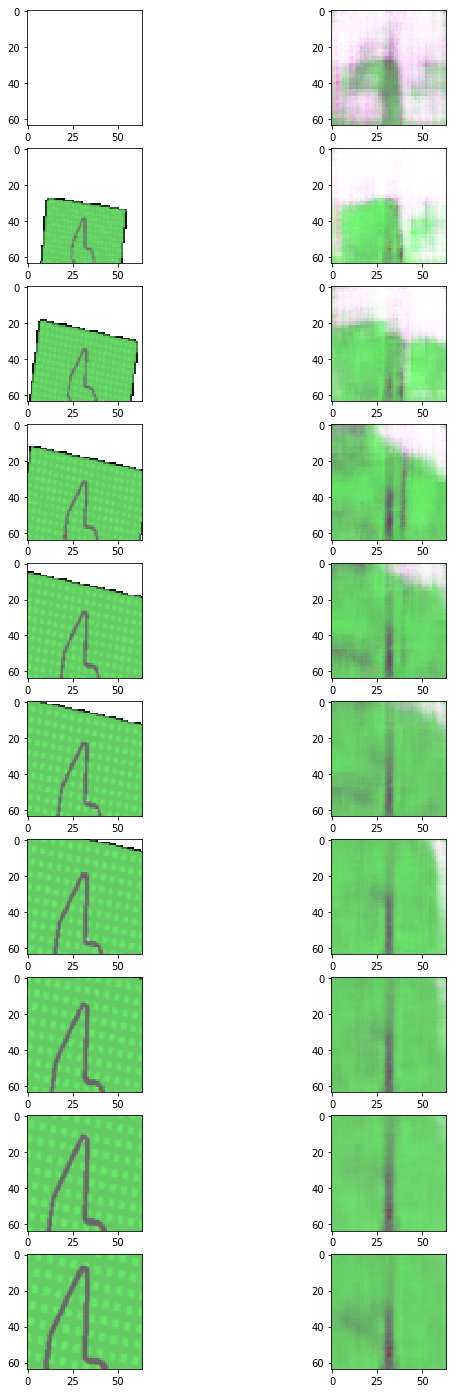

In [6]:
fig, axes = plt.subplots(10, 2, figsize=(10, 25))
for ax, im, gen in zip(axes, obs, predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[1].imshow(gen, interpolation='nearest')

# Visualize Autoencoder Latent Dimension

In [7]:
encoder = Model(inputs=vae.input,
                outputs=vae.get_layer('encoder').output)
out = encoder.predict(obs)

-0.9637599 0.95000875
-0.98271596
-1.0041289 0.9551489
1.0671602
-0.92962354 0.9933929
0.89437073
-1.0043323 0.92599934
0.10448284
-0.9641637 0.9890172
-0.49404207
-0.9987198 0.91608715
-0.8047912
-1.0273954 0.9913463
-0.4123216
-0.93376625 -0.49320218
-1.213104
-1.0189282 0.95743126
0.70245236
0.9110344 1.0860016
1.1246479


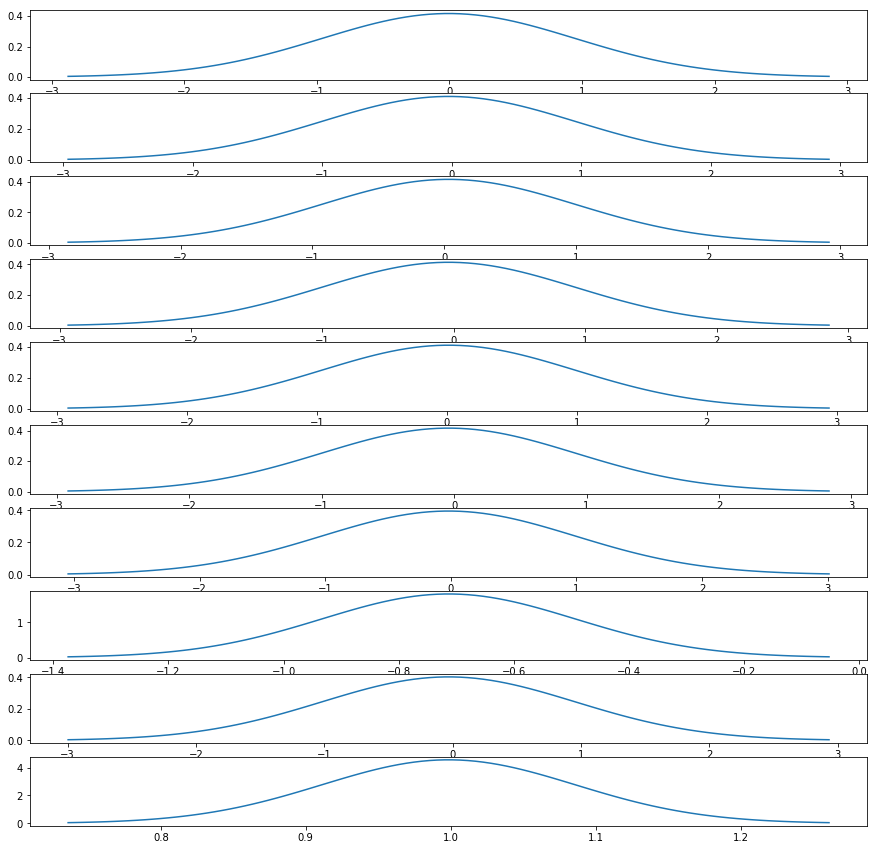

In [50]:
fig, axes = plt.subplots(10, figsize=(15, 15))
for i, ax, in enumerate(axes):
    mu = out[0][0][i]
    sigma = out[1][0][i]
    print(mu-sigma, mu + sigma)
    print(np.sum(out[2][0][i]))
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, norm.pdf(x, mu, sigma))

# Visualize RNN Output

In [8]:
rnn = get_rnn((None, 35))
rnn.load_weights('checkpoints/rnn.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rnn_input (InputLayer)          (None, None, 35)     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 256),  299008      rnn_input[0][0]                  
__________________________________________________________________________________________________
pis (Dense)                     (None, None, 160)    41120       lstm[0][0]                       
__________________________________________________________________________________________________
mus (Dense)                     (None, None, 160)    41120       lstm[0][0]                       
__________________________________________________________________________________________________
sigmas (De

#### Generate RNN input with encoder

In [17]:
z_true = encoder.predict(obs)[-1]
z_true = HDF5Matrix('data/test.h5', 'z', end=end)
rnn_input = np.column_stack([z_true, actions])[:-1]
rnn_input = np.reshape(rnn_input, (-1, 1, 35))

#### Predict on input

In [18]:
z_pred = rnn.predict(rnn_input)

#### Format rnn output

In [19]:
num_mixtures = 5
output_sequence_width = 32
# Flattened output sequences and mixtures
flat = output_sequence_width*num_mixtures
# Get number of sequences
rollout = np.shape(z_pred)[1]
# Extract flattened variables
pis_flat = z_pred[:,:,:flat]
mus_flat = z_pred[:,:,flat:flat*2]
sigmas_flat = z_pred[:,:,flat*2:flat*3]
# Reshape to (batch, time, num_mixtures, output_sequence_width)
shape = [-1, rollout, num_mixtures, output_sequence_width]
pis = np.reshape(pis_flat, shape)
mus = np.reshape(mus_flat, shape)
sigmas = np.reshape(sigmas_flat, shape)
# Send pis through softmax
pis = np.exp(pis) / np.sum(np.exp(pis), axis=2, keepdims=True)

#### Format ground truth data

In [20]:
# Reshape y to be (batch, time, output_sequence_width)
y = np.reshape(z_true[1:], [-1, rollout, output_sequence_width])
# Tile y to be (batch, time, num_mixtures*output_sequence_width)
y = np.tile(y, (1, 1, num_mixtures))
# Reshape to (batch, time, num_mixtures, output_sequence_width)
y = np.reshape(y, [-1, rollout, num_mixtures, output_sequence_width])

#### Probabilities that the ground truth would be generated by the distributions for the first image

In [21]:
gaussians = np.exp(-1/2*np.square((y - mus) / (sigmas + 1e-8))) / \
        (np.sqrt(2*math.pi*np.square(sigmas)) + 1e-8)
mixed = gaussians * pis
probabilities = np.sum(mixed, axis=2)
print(probabilities[100])

[[0.31488547 0.49395072 0.2404145  0.18145457 0.5223659  0.38159356
  0.7268409  0.569298   0.7598436  0.5314238  0.26457095 0.2335019
  0.27598304 3.0341117  0.34852052 3.7707465  0.8519613  0.94985354
  1.0908587  0.1559348  0.5532695  0.4865438  0.9451316  4.5823717
  0.3435902  0.17227371 0.56390005 0.2550666  0.12245438 0.06218592
  0.3445323  0.21934246]]


In [22]:
print(-np.log(probabilities[1000]+ 1e-8))

[[ 2.8047388  -1.726421   -0.5522993  -1.3771544  -0.48446327  1.6137474
  -0.5790373   2.7588313  -0.53482175 -0.8551467   1.9725595  -0.88406456
   2.299064    2.2199636   0.15829158  0.53751004 -1.314065   -1.2673769
   0.37844947  0.9372353  -0.1690105   1.6733865   1.6972011  -1.6919361
   1.1909988  -0.61282283  3.007512    1.4582063  -0.7495183   2.3822381
   4.878991   -1.2961838 ]]


In [23]:
print(len(gaussians[np.where(gaussians > 1)]))

260886


In [27]:
print(np.mean(-np.log(probabilities + 1e-8), axis=(0,1,2)))

0.6496506


In [32]:
flat = 5*32
pis_flat = z_pred[:,:,:flat]
mus_flat = z_pred[:,:,flat:flat*2]
sigmas_flat = z_pred[:,:,flat*2:flat*3]

shape = [-1, 1, 5, 32]
pis = np.reshape(pis_flat, shape)
mus = np.reshape(mus_flat, shape)
sigmas = np.reshape(sigmas_flat, shape)

In [54]:
print(mus.shape)
z_trues_zs = np.reshape(z_trues[-1], (10, 1, 32))
print(z_trues_zs.shape)
z_s = np.hstack([z_trues_zs, z_trues_zs, z_trues_zs, z_trues_zs, z_trues_zs])
print(z_s.shape)
z_s = np.reshape(z_s, [10, 1, 5, 32])[1:]
print(z_s.shape)

(9, 1, 5, 32)
(10, 1, 32)
(10, 5, 32)
(9, 1, 5, 32)


In [64]:
pdfs = pdf(z_s, pis, mus, sigmas)

In [68]:
print(pdfs[0][:,0])

[0.00186511 0.00143095 0.00142547 0.00201984 0.00176278]
